# Проектное задание по теме "Прогнозирование инсульта"

Выполнили: Исмаков Илья и Геер Максим из группы ПрИ-301

## Задание 
Необходимо изучить датасет взятый с Kaggle с данными о людях, в частности инсультов у них. Целью исслодования является нахождение лучшего алгоритма, который позволит как можно точней предсказать наличие инсульта у человека по проверочным данным.


## Подготовка данных

Импорт необходимых далее библиотек:

In [83]:
import pandas as pd
from scipy.stats import normaltest
import matplotlib.pyplot as plt
from time import time
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
from fastcore.parallel import *

#### Чтение CSV-файла с данными для обучения модели 
Было загружено, соединено и перемешано 2 файла с данными, подходящими для обучения модели. Помимо основного файла "train.csv" было взято также часть данных из датасета "healthcare-dataset-stroke-data.csv". Этот датасет служил источником для обучения нейросети, благодаря которой и были полученны данные из "train.csv" и данные для проверки модели. Дополнительный датасет был рекомендован к использованию многими участниками этого соревания. Не смотря на то, что он имеет меньше сгенерированных данных, он может помочь уменьшить сильную несбалансированность между людьми с инсультом и без в исходных данных.

In [84]:
train_df = pd.read_csv("train.csv", index_col=0)
origin_df = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=0)

# присоединение из изначальных данных строки, где "stroke = 1"
origin_df = origin_df.dropna()
origin_df = origin_df[origin_df['stroke'] == 1]
print(len(train_df))
train_df = pd.concat([train_df, origin_df])
print(len(train_df))

# перемешивание данных
idx = np.random.RandomState(seed=42).permutation(len(train_df))
train_df = train_df.iloc[idx].reset_index(drop=True)
train_df

15304
15513


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,44.00,0,0,Yes,Govt_job,Urban,87.95,26.3,Unknown,0
1,Female,75.00,0,0,Yes,Self-employed,Urban,78.16,34.5,never smoked,1
2,Female,23.00,0,0,No,Private,Urban,82.64,41.8,never smoked,0
3,Male,0.56,0,0,No,children,Rural,56.33,14.1,Unknown,0
4,Male,44.00,0,0,Yes,Private,Rural,56.11,27.6,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15508,Male,45.00,0,0,Yes,Govt_job,Urban,120.56,31.6,never smoked,0
15509,Male,56.00,0,0,Yes,Self-employed,Urban,76.51,28.4,never smoked,0
15510,Female,31.00,0,0,Yes,Private,Rural,82.57,30.7,smokes,0
15511,Female,53.00,0,0,Yes,Govt_job,Urban,68.68,31.1,smokes,0


## Исследование данных

Имеется 15304+209 строк данных с 11-ю столбцами, главным из которых является столбец "stroke", обозначающий принадлежность человека к группе людей, подверженых инсульту. Среди данных есть как числа с плавающей запятой, так и строки и столбцы со значениями только 0 и 1. Пропусков и None значений в строках не присутствует (они присутствовали в оригинальном наборе данных, но от туда они были легко отсеяны, как показано в коде выше).

In [85]:
# как можно заметить, пропусков в данных нет.
train_df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Далее для исследования данных на их основе будут отрисованных графики, по которым можно будет сделать новые выводы:

Text(0.5, 1.0, 'Соотношение места проживания сердца "stroke = 1"')

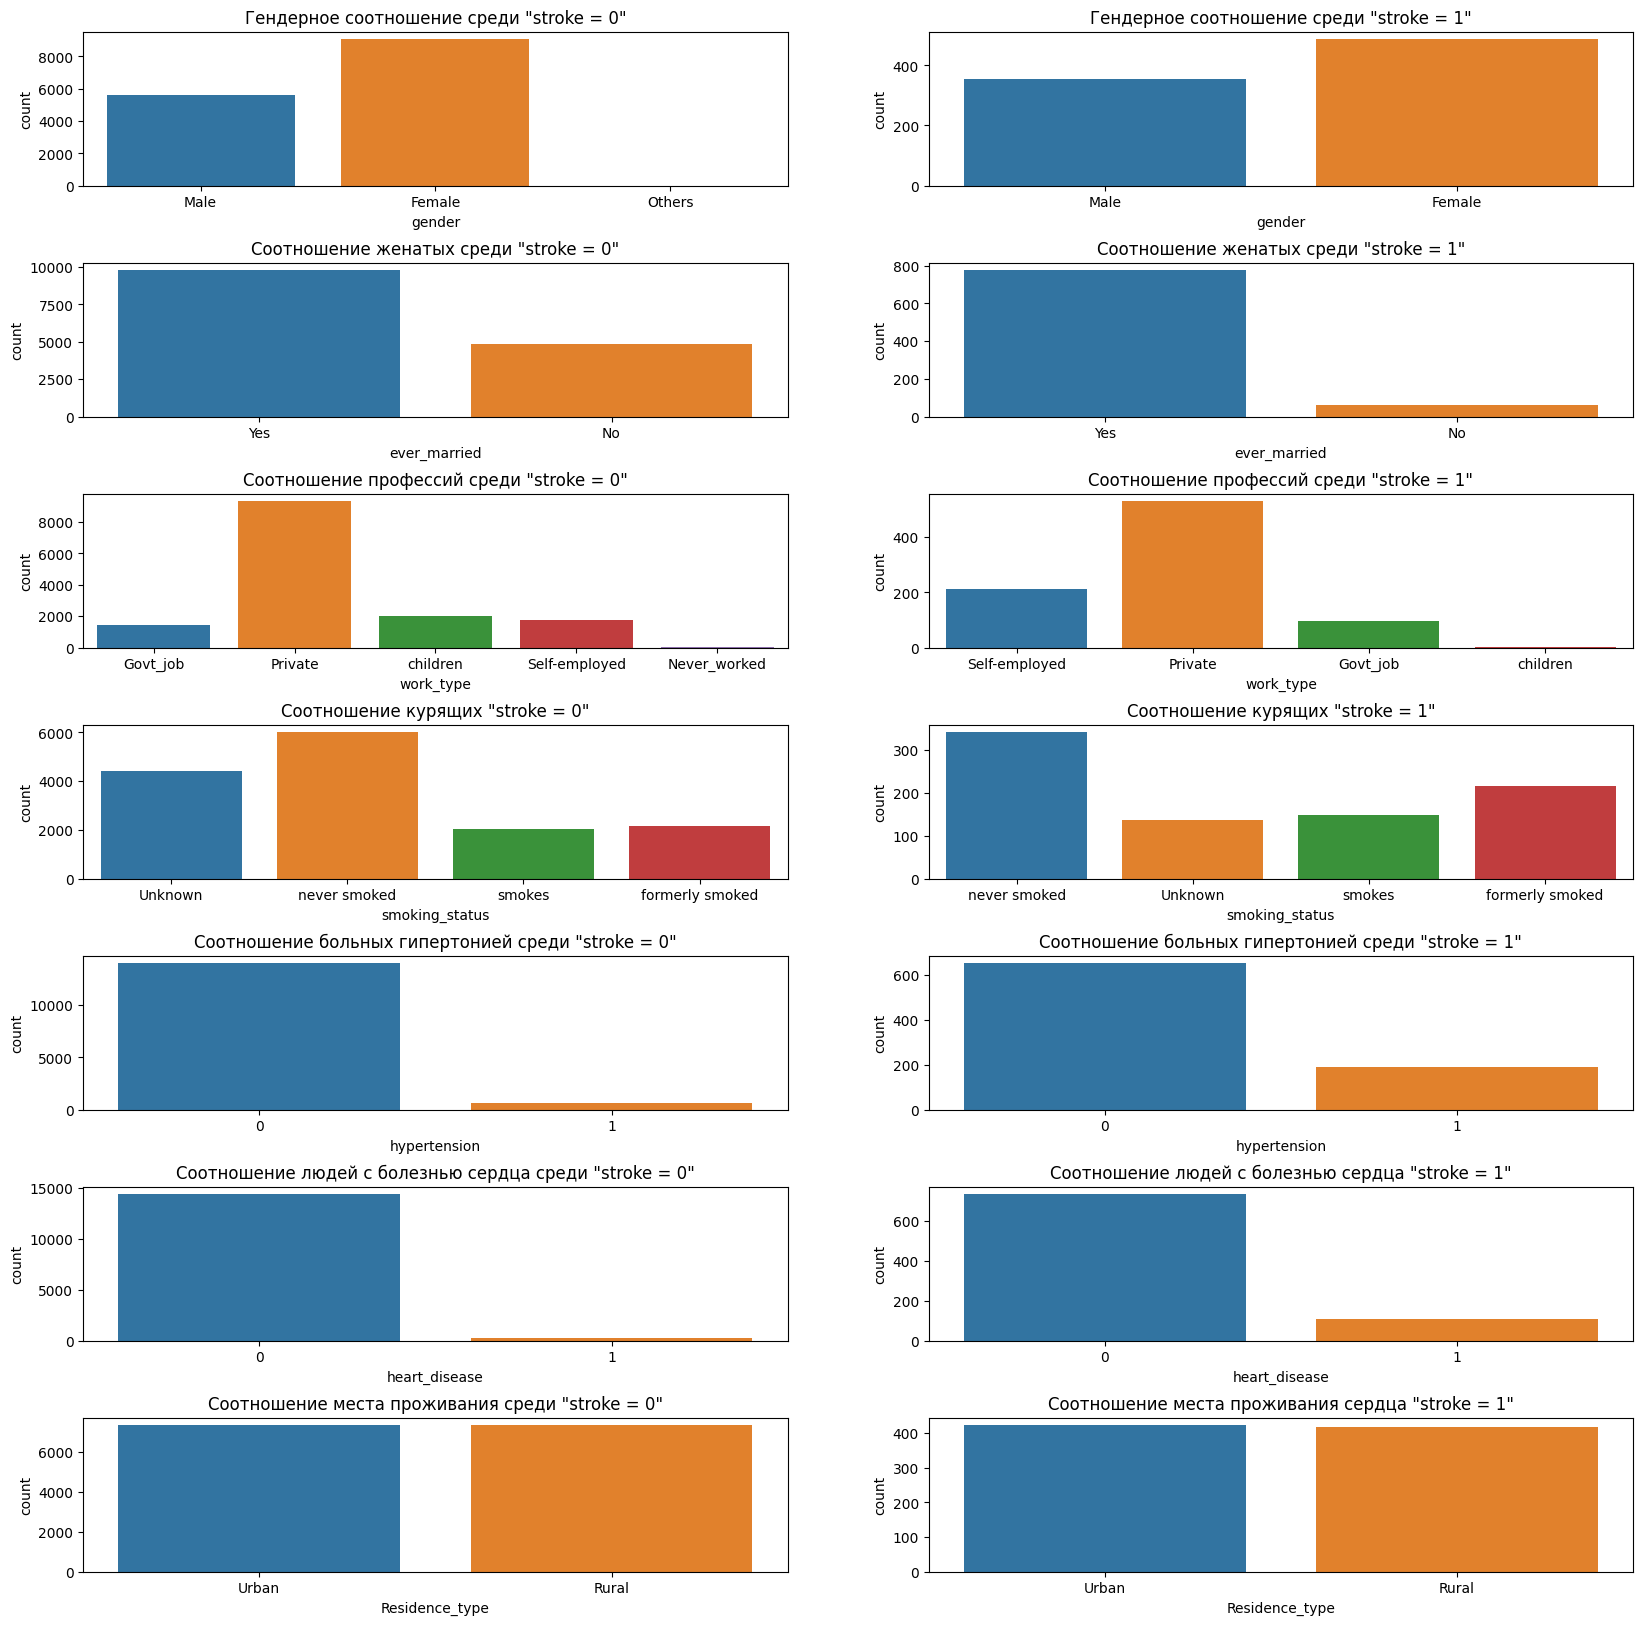

In [86]:
fig, axes = plt.subplots(7, 2, figsize = (20, 20))
fig.subplots_adjust(hspace=0.5)

ax = sns.countplot(ax=axes[0, 0], x = "gender", data = train_df[train_df.stroke == 0], order=['Male', 'Female', 'Others'])
ax.set_title('Гендерное соотношение среди "stroke = 0"')
ax = sns.countplot(ax=axes[0, 1], x = "gender", data = train_df[train_df.stroke == 1], order=['Male', 'Female'])
ax.set_title('Гендерное соотношение среди "stroke = 1"')

ax = sns.countplot(ax=axes[1, 0], x = "ever_married", data = train_df[train_df.stroke == 0])
ax.set_title('Соотношение женатых среди "stroke = 0"')
ax = sns.countplot(ax=axes[1, 1], x = "ever_married", data = train_df[train_df.stroke == 1])
ax.set_title('Соотношение женатых среди "stroke = 1"')

ax = sns.countplot(ax=axes[2, 0], x = "work_type", data = train_df[train_df.stroke == 0])
ax.set_title('Соотношение профессий среди "stroke = 0"')
ax = sns.countplot(ax=axes[2, 1], x = "work_type", data = train_df[train_df.stroke == 1])
ax.set_title('Соотношение профессий среди "stroke = 1"')

ax = sns.countplot(ax=axes[3, 0], x = "smoking_status", data = train_df[train_df.stroke == 0])
ax.set_title('Соотношение курящих "stroke = 0"')
ax = sns.countplot(ax=axes[3, 1], x = "smoking_status", data = train_df[train_df.stroke == 1])
ax.set_title('Соотношение курящих "stroke = 1"')

ax = sns.countplot(ax=axes[4, 0], x = "hypertension", data = train_df[train_df.stroke == 0])
ax.set_title('Соотношение больных гипертонией среди "stroke = 0"')
ax = sns.countplot(ax=axes[4, 1], x = "hypertension", data = train_df[train_df.stroke == 1])
ax.set_title('Соотношение больных гипертонией среди "stroke = 1"')

ax = sns.countplot(ax=axes[5, 0], x = "heart_disease", data = train_df[train_df.stroke == 0])
ax.set_title('Соотношение людей с болезнью сердца среди "stroke = 0"')
ax = sns.countplot(ax=axes[5, 1], x = "heart_disease", data = train_df[train_df.stroke == 1])
ax.set_title('Соотношение людей с болезнью сердца "stroke = 1"')

ax = sns.countplot(ax=axes[6, 0], x = "Residence_type", data = train_df[train_df.stroke == 0])
ax.set_title('Соотношение места проживания среди "stroke = 0"')
ax = sns.countplot(ax=axes[6, 1], x = "Residence_type", data = train_df[train_df.stroke == 1])
ax.set_title('Соотношение места проживания сердца "stroke = 1"')

Из графиков выше видно следующее влиянеие на целевую фичу:
1. Гендер слабо влияет
2. Не женатые значительно чаще страдают от инсульта
3. Люди с профессией "Children" почти не подвержены инсультам
4. Никогда не курившие люди реже подвержаны инсультам
5. Больные гипертонией чаще страдают от инсульта
6. Люди с болезнью сердца незначительно чаще страдают от инсульта

С учётом того, что в выборке количество людей с инсультом кратно меньше людей без (видно на графике ниже), то на таких малых значениях данные должны существенно скакать, из-за чего незначительные отклонения (как у гендера и болезни сердца) могут быть вызваны скорей этими скачками, чем корелляцией

Соотношение:  841 к 14672


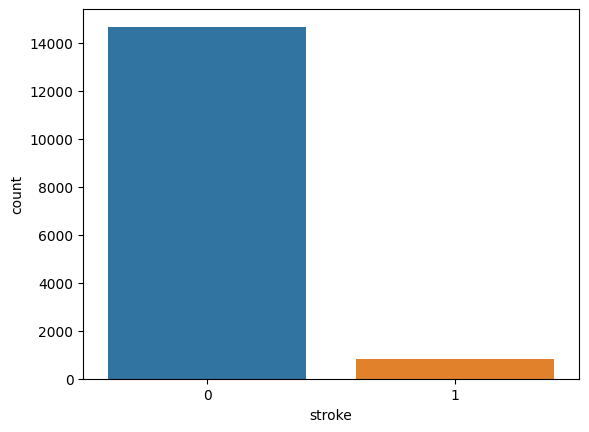

In [87]:
sns.countplot(x = "stroke", data = train_df)
print("Соотношение: ", len(train_df[train_df.stroke == 1]), "к", len(train_df[train_df.stroke == 0]))

На графике выше видно соотношение людей с иснультом и без в выборке - их всего примерно 5%, что, даже с учётом добавленных строк, создаёт сильную несбалансированность данных, являющуюся основной проблеммой данного датасета.

<AxesSubplot:xlabel='bmi', ylabel='age'>

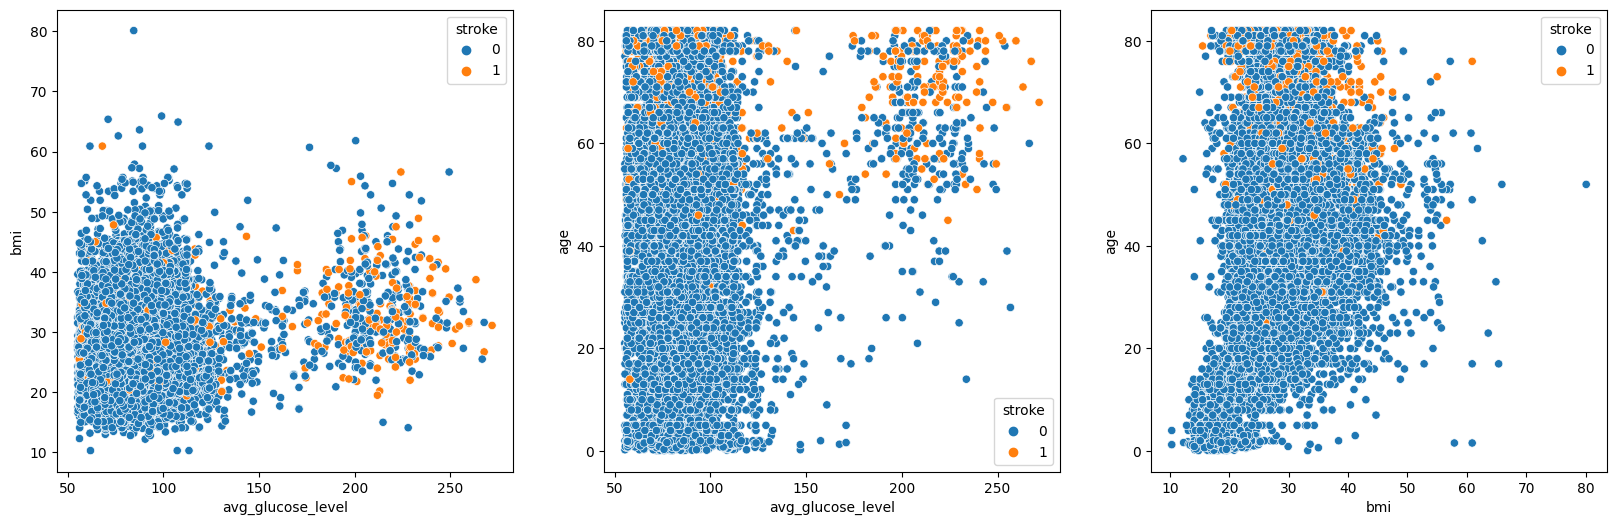

In [88]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6))

sns.scatterplot(ax = axes[0], x = 'avg_glucose_level', y = 'bmi', data = train_df, hue='stroke')
sns.scatterplot(ax = axes[1], x = 'avg_glucose_level', y = 'age', data = train_df, hue = 'stroke')
sns.scatterplot(ax = axes[2], x = 'bmi', y = 'age', data = train_df, hue = 'stroke')

Из графиков выше видно:
1. В первую очередь на вероятность инсульта влияет возраст
1. Уровень глюкозы также коллерирует с частотой возникновения инсульта
2. Не видно коллеряции индекса массы тела с инсультами

На графике ниже можно увидеть одну из сложностей датасета - нет четкого разделения на классы.
Он был получен с помошью алгоритма TSNE, который позволяет снижать размерность. В данном случае алгоритм используется для проекции всех данных датасета на плоскости:

In [89]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# tsne = TSNE(n_components=2, random_state=42)
# X_tsne = tsne.fit_transform(x_train)

# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train/2)
# plt.show()

## Обработка данных
Некоторые факторы содержат строковые значения. Такие данные необходимо закодировать в числовом формате и, при необходимости, разбить на несколько факторов, что и проделывает в коде ниже:

In [90]:
# преобразование строк в числа и разбиение столбцов 
def transformData(train_df):
    train_df['never_smoked'] = train_df.apply(lambda row: 1 if row[9] == 'never smoked' else 0, axis=1)
    train_df_clean = train_df.replace({'gender': {'Male': 0, 'Other': 0.5, 'Female': 1}})
    train_df_clean = train_df_clean.replace({'ever_married': {'Yes': 1, 'No': 0}})
    dummies = pd.get_dummies(train_df['work_type'], dtype=int)
    train_df_clean = train_df_clean.drop('work_type', axis=1)
    train_df_clean = pd.concat([train_df_clean, dummies], axis=1)
    train_df_clean = train_df_clean.replace({'Residence_type': {'Urban': 1, 'Rural': 0}})
    train_df_clean = train_df_clean.replace({'smoking_status': {'never smoked': 0, 'Unknown': 0.33, 'formerly smoked': 0.66, 'smokes': 1}})
    return train_df_clean

train_df_clean = transformData(train_df)
train_df_clean

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,never_smoked,Govt_job,Never_worked,Private,Self-employed,children
0,1.0,44.00,0,0,1,1,87.95,26.3,0.33,0,0,1,0,0,0,0
1,1.0,75.00,0,0,1,1,78.16,34.5,0.00,1,1,0,0,0,1,0
2,1.0,23.00,0,0,0,1,82.64,41.8,0.00,0,1,0,0,1,0,0
3,0.0,0.56,0,0,0,0,56.33,14.1,0.33,0,0,0,0,0,0,1
4,0.0,44.00,0,0,1,0,56.11,27.6,0.00,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15508,0.0,45.00,0,0,1,1,120.56,31.6,0.00,0,1,1,0,0,0,0
15509,0.0,56.00,0,0,1,1,76.51,28.4,0.00,0,1,0,0,0,1,0
15510,1.0,31.00,0,0,1,0,82.57,30.7,1.00,0,0,0,0,1,0,0
15511,1.0,53.00,0,0,1,1,68.68,31.1,1.00,0,0,1,0,0,0,0


Изходя из анализа данных также было решено добавить фичу "never_smoked", которая будет использоваться вместо фичи "smoking_status" т.к. из имеющихся в ней значений только значение never smoked коррелирует с целейвой фичей "stroke". То же косается значения "children" поля "work_type" - оно единственное существенно коллерирует со "stroke".

Далее найдём корреляцию всех фич с фичей "stroke":

<function matplotlib.pyplot.show(close=None, block=None)>

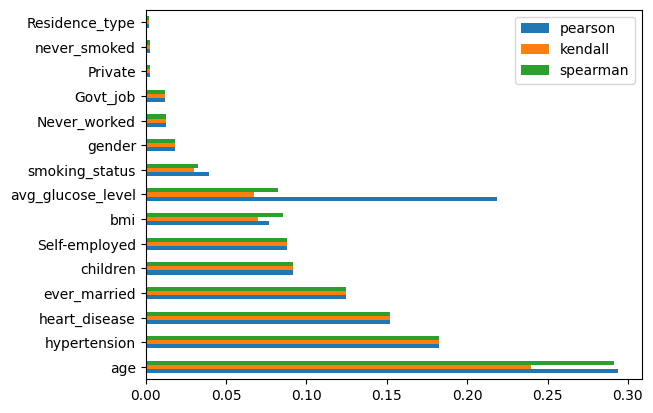

In [91]:
cpearson_corr = pd.Series.abs(train_df_clean.corr(method='pearson')['stroke']) # корреляция по методу Пирсона
kendall_corr = pd.Series.abs(train_df_clean.corr(method='kendall')['stroke']) # корреляция по методу Кендалла
spearman_corr = pd.Series.abs(train_df_clean.corr(method='spearman')['stroke']) # корреляция по методу Спирмена
corr_result = pd.concat([cpearson_corr, kendall_corr, spearman_corr], keys=['pearson', 'kendall', 'spearman'], axis=1)
corr_result = corr_result.sort_values(by='kendall', ascending=False)[1:]
corr_result

corr_result.plot.barh()
plt.show

Метод Пирсона можно использовать только при наличии нормального распределения, поэтому проведем небольшую проверку.

In [92]:
# Проверка на наличие нормального распределения
columns_new = []
values_new = []
for column in train_df_clean.columns :
    p_value_factor = normaltest(train_df_clean[column]).pvalue
    columns_new.append(column)
    if p_value_factor > 0.05:
        values_new.append("+")
    else:
        values_new.append("-")
result = pd.DataFrame({'Фича': columns_new, 'имеет нормальное распределение': values_new})
result


,Фича,имеет нормальное распределение
0,gender,-
1,age,-
2,hypertension,-
3,heart_disease,-
4,ever_married,-
5,Residence_type,-
6,avg_glucose_level,-
7,bmi,-
8,smoking_status,-
9,stroke,-


Проверка показала, что все поля не имеют нормального распределения, следовательно мы можем использвать либо корреляцию по методу Кендалла, либо по методу Спирмена.
При этом, на таблице выше видно, что методы Кендалла и Спирмена имеют схожие значения. На них и будем опираться.

На графике выше видна корреляция для каждого из параметров относительно "stroke", выполненная 3-мя разными методами. Здесь виден скачок после ever_married, что свидетельствет о том, что она, и все метрики важнее её, должны быть взяты для обучения модели. Что же касается менее коррелирующих метрик, не все из них не будут отброшены. Часть будет оставлена с опорой на результаты изначальных исследований данных.

In [93]:
# отбор фич для обучения модели
def filterFeatures(train_df_clean):
    features = kendall_corr[(kendall_corr > 0) | (kendall_corr == 1)]
    features.sort_values(ascending=False)[1:]
    features = features.drop(['smoking_status', "gender", 'bmi', 'Private', 'Self-employed', 'Residence_type', 'Never_worked', 'Govt_job'])
    return features

features = filterFeatures(train_df_clean)
features

age                  0.239788
hypertension         0.182460
heart_disease        0.152293
ever_married         0.124595
avg_glucose_level    0.067071
stroke               1.000000
never_smoked         0.002352
children             0.091450
Name: stroke, dtype: float64

Взяты все фичи, кроме перечисленных в features.drop. Они не были взяты из-за низкого значения корелляции со "stroke" или из-за непрослежеваемой связи с целевой метрикой при анализе данных.

Также, во время исследования, были произведены попытки добавления новых фич путём совмещения вместе старых. Такой способ был замечен в ряде решений на Kaggle. Однако, добавление ни одной из этих фич не улучший, а даже ухудшил качество обучения моделей. Ровно как и пыпотки нормализации числовых данных и деление на классы по возрасту. Ниже привеедены некоторые метрики, которые были добавлены, но затем удалены из-за негативного влияния на результат обучения:
 ```python
train_df_clean['age/bmi'] = train_df_clean.age / train_df_clean.bmi
train_df_clean['age*bmi'] = train_df_clean.age * train_df_clean.bmi
train_df_clean['bmi/prime'] = train_df_clean.bmi / 25
train_df_clean['obesity'] = train_df_clean.avg_glucose_level * train_df_clean.bmi / 1000
train_df_clean['blood_heart']= train_df_clean.hypertension*train_df_clean.heart_disease
```

In [94]:
# избавление от незначащих фич
train_df_clean = train_df_clean.filter(features.index)
train_df_clean

,age,hypertension,heart_disease,ever_married,avg_glucose_level,stroke,never_smoked,children
0,44.00,0,0,1,87.95,0,0,0
1,75.00,0,0,1,78.16,1,1,0
2,23.00,0,0,0,82.64,0,1,0
3,0.56,0,0,0,56.33,0,0,1
4,44.00,0,0,1,56.11,0,1,0
...,...,...,...,...,...,...,...,...
15508,45.00,0,0,1,120.56,0,1,0
15509,56.00,0,0,1,76.51,0,1,0
15510,31.00,0,0,1,82.57,0,0,0
15511,53.00,0,0,1,68.68,0,0,0


Далее была произведена попытка удаления из данных выбросов, используя алгоритм DBSCAN. Он прекрасно спраравился с этой задачей, однако удаление выбросов привело к снижению всех наблюдаемых метрик (кроме accuracy в некоторых случаях) при обучении на большенстве проверенных нами моделей. Предположительно, это связано с присудствием среди выбросов данных где stroke = 1, которые были удалены, что только повысило несбалансированность данных.

Код, использованный для избавления от выбросов:
``` python
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=4)
labels = dbscan.fit_predict(train_df_clean)
filtered_data = train_df_clean[labels != -1]
print(len(train_df_clean))
print(len(filtered_data))
filtered_data
train_df_clean = filtered_data
```

## Разделение dataFrame на тестовую и тренировочную выборки

Исходя из проверки разных способов оказалось, что способ разделения данных на тренировочную и тестовую выборки влияет на качество обучения модели. Ниже представлено простое разделение в пропорции 20/80, которое не дало должного результата:

Ручное разделение:
<hr style="border:2px solid gray; margin-left:0;" width="600px" >

```python
test_length_border = int(len(train_df_clean_outlierless) * 0.8)
test_df_clean_temp = train_df_clean_outlierless[test_length_border : ]
train_df_clean_temp = train_df_clean_outlierless[ : test_length_border]

x_train = train_df_clean_temp.drop(columns='stroke')
y_train = train_df_clean_temp['stroke']

x_test = test_df_clean_temp.drop(columns='stroke')
y_test = test_df_clean_temp['stroke']
```

<hr style="border:2px solid gray; margin-left:0;" width="600px" >




Автоматическое разделение:
<hr style="border:2px solid gray; margin-left:0;" width="600px" >

```python
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_df_clean.drop(columns='stroke'), 
    train_df_clean.loc[:, ['stroke']], random_state=2,test_size=0.2)
```

<hr style="border:2px solid gray; margin-left:0;" width="600px" >

StratifiedKFold производит более умное разделение данных и, следовательно, показывает наилучший результат при обучении моделей.\
**Пояснение:**
> StratifiedKFold - разновидность k-fold алгоритма. k-fold (она же "перекрестная проверка"), в свою очередь, действует примерно по такому алгоритму: 
> 1. Перемешайте датасет случайным образом
> 2. Разделите датасет на k-групп
> 3. Для каждой уникальной выборки:
>       - Возьмите группу в качестве тестирования датасета
>       - Возьмите остальные группы в качестве выборки учебных данных
>       - Приготовьте модель на обучаемых выборках и оцените ее на тестовой выборке
>       - Сохраняйте оценку модели и отбросьте модель
>4. Обобщите параметры качества модели с помощью выборки оценки моделей

In [95]:
# Выделение тестовых данных
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)

all_featers = train_df_clean.drop(columns='stroke')
factor = train_df_clean['stroke']

for train_index, test_index in skf.split(all_featers, factor):
    x_train, x_test = all_featers.iloc[train_index], all_featers.iloc[test_index]
    y_train, y_test = factor.iloc[train_index], factor.iloc[test_index]
print(len(y_test), len(y_test[y_test == 1]))
print(len(y_train), len(y_train[y_train == 1]))

1551 84
13962 757


## Первичное обучение моделей

Далее будет произведено обучение нескольких моделей, про выбор которых будет более подробно рассказано далее. Цель данного блока - продемонстрировать качество исходных данных.

Обучение 3-х различнчх моедлей:

In [96]:
# логистическая регрессия
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver="newton-cg")
lr_model.fit(x_train, y_train)
lr_y_pred = lr_model.predict(x_test)

In [97]:
# Метод случайного леса
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=200, n_estimators=200)
rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)

In [98]:
# градиентный бустинг
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=200, n_estimators=600, learning_rate=0.08, max_depth=3, min_child_samples=17, num_leaves=6, n_jobs=-1)
lgbm_model.fit(x_train, y_train)
lgbm_y_pred = lgbm_model.predict(x_test)

Теперь произведём замеры точности:

In [99]:
from sklearn.metrics import accuracy_score

print("LogisticRegression:", accuracy_score(y_test, lr_y_pred))
print("RandomForestClassifier:", accuracy_score(y_test, rf_y_pred))
print("LGBMClassifier:", accuracy_score(y_test, lgbm_y_pred))

LogisticRegression: 0.9464861379754996
RandomForestClassifier: 0.927143778207608
LGBMClassifier: 0.9458413926499033


Здесь мы видим не самую плохую точность в примерно 95%. Однако, вспоминаем про обговоренную выше несбалансированность данных и решаем проверить другие метрики, более зависящие от неё:

In [100]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("LogisticRegression:\n", 
    "\tPrecision:", precision_score(y_test, lr_y_pred), "\n",
    "\tRecall:", recall_score(y_test, lr_y_pred), "\n",
    "\tF1:", f1_score(y_test, lr_y_pred), "\n")
print("RandomForestClassifier:\n",
    "\tPrecision:", precision_score(y_test, rf_y_pred), "\n",
    "\tRecall:", recall_score(y_test, rf_y_pred), "\n",
    "\tF1:", f1_score(y_test, rf_y_pred), "\n")
print("LGBMClassifier:\n",
    "\tPrecision:", precision_score(y_test, lgbm_y_pred), "\n",
    "\tRecall:", recall_score(y_test, lgbm_y_pred), "\n",
    "\tF1:", f1_score(y_test, lgbm_y_pred))

LogisticRegression:
 	Precision: 0.5263157894736842 
 	Recall: 0.11904761904761904 
 	F1: 0.1941747572815534 

RandomForestClassifier:
 	Precision: 0.27692307692307694 
 	Recall: 0.21428571428571427 
 	F1: 0.24161073825503354 

LGBMClassifier:
 	Precision: 0.5 
 	Recall: 0.15476190476190477 
 	F1: 0.23636363636363636


Здесь уже чуть лучше видно, в чём подвох: несмотря на высокую точность мы имеем 12%-21% recall и в среднем 23% значение метрики F1. Это очень мало! Особенно учитывая специфику задачи (предсказание инсультов), главной метрикой для нас является Recall. Настолько низкие значения говорят о плохой обученности моделей. А так как такие показатели выдали 3 разные модели, то проблема скорее в данных. Так что же произошло? Взглянем на матрицу ошибок для RandomForestClassifier:

[[1458    9]
 [  74   10]]


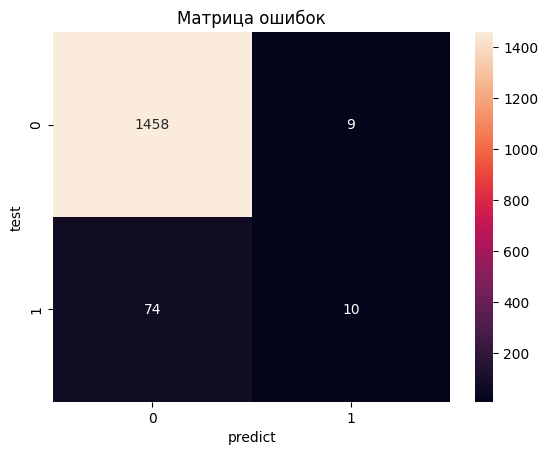

In [101]:
from sklearn import metrics

def print_error_matrix(y_test, y_pred) :
    data = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1])
    print(data)
    ax = sns.heatmap(data, annot=True, fmt="d")
    plt.title("Матрица ошибок", fontsize=12)
    plt.xlabel('predict') 
    plt.ylabel('test') 
    plt.show()

print_error_matrix(y_test, lr_y_pred)

Отсюда становится видно в чем проблема: из-за несбалансированноcти данных, модели решили, что лучшей стратегией будет приписывать всех пациентов к числу здоровых. В игоге получаем, что только около 15% людей с инсультом были отнесены к правильной категории. Остальные же ~~не получат медицинсукую помощь~~ отнесены не в ту категорию. Отсюда и имеем точность почти в 95%, ведь остальные 5% это и есть люди с инсультом. Случайный лес справился чуть лучше, но лишь потому, что бил шире. Однако же, и ему не хватило выборки, чтобы научиться отличать больных от здоровых.

В данном ноутбуке мы описали вариант, если бы у нас стояла задача разработать инструмент для определения вероятности наличия болезни у человека. Для соревновании в Kaggle мы использовали вариант без семплинга данных, т.к. он показывал более высокий accuracy, но низкий F1, как показано выше. Вероятно соревнование Kaggle не учитывает специфику предметной области, из-за чего мы не согласны с его методом расчёта счёта.

## Перебалансировка данных

В тренировочной выборке stroke = 0 превышает stroke = 1 в более чем 18 раз! Для борьбы с этим было решено провести перебалансировку сокращением данных где stroke = 0 и генерацией искуственных данных, где stroke = 1. Для генерации данных были протестированы resample и SMOTE. В ходе экспериментов SMOTE показал себя, как более эффективный алгоритм.

#### Undersampling
Для уменьшения мажоритарного класса мы использовали метод случайного удалениея элементов выборки, где stroke = 0. Здесь *k = 0.7* означает, что алгоритм случайным образом удалит 30% данных, где stroke = 0.

In [102]:
import numpy as np

# субдескретизация уменьшением элементов до k где stroke = 0
k = 0.7
random_state = 42
zero_idx = np.array(y_train[y_train == 0].index)
subset_idx = np.random.RandomState(random_state).choice(zero_idx, size=int(k*len(zero_idx)), replace=False)

one_idx = np.array(y_train[y_train == 1].index)
c = np.concatenate((subset_idx, one_idx), axis=0)
print(len(x_train))
x_train = x_train.loc[c].sort_index()
y_train = y_train.loc[c].sort_index()
print(len(x_train))

13962
10000


Другой, хорошо проявивший себя алгоритм - алгоритм избавляющийся от связей Томека (объекты двух разных классов образуют связь Томека, если нет объекта, который ближе к одному из них при этом являясь объектом другого класса).

In [103]:
# избавление от связей Томека
from imblearn.under_sampling import TomekLinks
tomek = TomekLinks()
print(len(x_train))
x_tomek, y_tomek = tomek.fit_resample(x_train, y_train)
x_train, y_train = x_tomek, y_tomek
print(len(x_tomek))


10000
9756


Также был попробован алгоритм сосредоточения ближайшего соседа, однако он продемонстрировал себя хуже чем обратный ему с удалением связей Томека.

Использованный код код:
<hr style="border:2px solid gray; margin-left:0;" width="600px" >

```python
from imblearn.under_sampling import CondensedNearestNeighbour
cnn = CondensedNearestNeighbour(random_state=42) 
print(len(x_train))
x_tomek, y_tomek = cnn.fit_resample(x_train, y_train)
x_train, y_train = x_tomek, y_tomek
print(len(x_tomek))
```

<hr style="border:2px solid gray; margin-left:0;" width="600px" >

#### Oversampling

Изначально был опробован тривиальный алгоритм с простым дублированием элементов минорного класса, но он только ухудшил метрики обучения моделей:

<hr style="border:2px solid gray; margin-left:0;" width="600px" >

```python
n = 1
for i in range(n) :
    x_train = np.concatenate((x_train, x_train.loc[one_idx]))
    y_train = np.concatenate((y_train, y_train.loc[one_idx]))
    print(len(x_train))
```

<hr style="border:2px solid gray; margin-left:0;" width="600px" >

Намного лучший результат показал алгоритм SMOTE (Synthetic Minority Oversampling Technique). Во многом с помошью него и подбора коэффециента для его параметра sampling_strategy удалось добиться существенного повышения метрики F1. 

In [104]:
# генерация искусственных данных с помощью SMOTE
smote = SMOTE(sampling_strategy=0.13, random_state=8765)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print("Новая длина выборки:", len(x_train_smote))
print("Изначально равно еденице: ", len(y_train[y_train==1]))
print("Теперь равно еденице: ", len(y_train_smote[y_train_smote==1]))
x_train = x_train_smote
y_train = y_train_smote

Новая длина выборки: 10168
Изначально равно еденице:  757
Теперь равно еденице:  1169


Помимо SMOTE был также опробован другой алгоритм оверсемплирования, но SMOTE показал себя лучше.

Код альтернативы SMOTE:

<hr style="border:2px solid gray; margin-left:0;" width="900px" >

```python
#PYTHON
train_df_merged = pd.concat([x_train, y_train], axis=1)

print(len(train_df_merged[train_df_merged['stroke'] == 1]))
train_minor = train_df_merged[(train_df_merged["stroke"] == 1)]
train_major = train_df_merged[(train_df_merged["stroke"] == 0)]

from sklearn.utils import resample, shuffle

minor_upsampled = resample(train_minor, n_samples=int(len(train_minor)*1.7), random_state=77)

train_df_merged = pd.concat([minor_upsampled, train_major], ignore_index=True)
train_df_merged = shuffle(train_df_merged,random_state=7)
print(len(train_df_merged[train_df_merged['stroke'] == 1]))

x_train, y_train = train_df_merged.drop(columns='stroke'), train_df_merged['stroke']
```

<hr style="border:2px solid gray; margin-left:0;" width="900px" >

## Обучение моделей

Мы проводили экспериметы с обучением семи моделей и исользованием ансамбля.

Хороший результат показали: **Light Gradient Boosting Machine** (LGBMClassifier), **Extreme Gradient Boosting** (XGBClassifier), **CatBoost** (CatBoostClassifier от Яндекс, мое почтение), а также ансамбль из этих трех моделей. Стоит обратить внимание на то, что все эти модели являются вариациями градиентного бустинга. 

**Decision Tree** (DecisionTreeClassifier) и **Random Forest** (RandomForestClassifier) слишком быстро переобучались, из-за чего сбивали нас с толку своими идеальными метриками (они разбили нам сердце и украл лучшие дни наших дедлайнов).

**Naive Bayes** (GaussianNB) и **Logistic Regression** показывали слишком плохие метрики (в дальнеших экспериментах им было уделено меньше всего внимания, как наиболее неэффективным).

#### Пара слов о метриках
Для определения эффективности обучения мы использовали следующие метрики: accuracy, recall, ROC_AUC, precision и f1.
Спицифика задачи такова, что главной метрикой для нас должен являться recall (нам важно определить наличие болезни у человека, мы не можем пропустить ни одного больного, но можем ошибочно определить здорового человека, как больного). Однако ретинг сайта Kaggle не учитывает эту тонкость, поэтому при настройке моделей мы сосредоточились именно на общей точности моделей, соответственно основной и наиболее важной метрикой для нас стал accuracy.
***
Что такое ROC AUC:
> Area Under Curve – площадь под кривой\
> Receiver Operating Characteristic – рабочая характеристика приёмника\
> Чем выше показатель AUC, тем качественнее модель, при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию). Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными и наоборот, классификатор будет работать лучше.\
$ROC=\frac{TPR}{FPR}$, \
        где TPR - True Positive Rate ($TPR=\frac{TP}{TP + FN}$)\
        FPR - False Positive Rate ($FPR=\frac{FP}{FP + TN}$)

Accuracy:
> Accuracy — это показатель, который описывает общую точность предсказания модели по всем классам.\
$Accuracy=\frac{TP+TN}{TP+FP+FN+TN}$

Precision:
> Precision представляет собой отношение числа семплов, верно классифицированных как Positive, к общему числу выборок с меткой Positive (распознанных правильно и неправильно). Precision измеряет точность модели при определении класса Positive.\
$Precision = \frac{TP}{TP + FP}$

Recall:
> Recall измеряет способность модели обнаруживать выборки, относящиеся к классу Positive. Чем выше recall, тем больше Positive семплов было найдено.\
$Recall = \frac{TP}{TP + FN}$

F1:
> Показатель F1 можно интерпретировать как среднее гармоническое между *precision* и *recall*\
$F1 = 2 * \frac{precision * recall}{precision + recall}$

In [105]:
# методы для отображения метрик
from sklearn.metrics import roc_auc_score

def print_metrics(y_test, y_pred) : 
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("Precision:", precision, "    Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1:", f1)
    
def print_score(model, x_test) :
    score = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    print("Score:", score)


In [106]:
# сюда будем добавлять результаты предсказаний моделей для ансамбля моделей
y_predictions = []

Naive Bayes:

In [107]:
from sklearn.naive_bayes import GaussianNB

# обучаем модель
nb = GaussianNB()
nb.fit(x_train, y_train)

# оцениваем точность
y_pred = nb.predict(x_test)
print_metrics(y_test, y_pred)
print_score(nb, x_test)

Precision: 0.24150943396226415     Recall: 0.7619047619047619
Accuracy: 0.8575112830431979
F1: 0.36676217765042984
Score: 0.8932304346414777


Логистическая регрессия:

In [108]:
from sklearn.linear_model import LogisticRegression

# обучаем модель
lr_model = LogisticRegression(solver="newton-cg")
lr_model.fit(x_train, y_train)

# оцениваем точность 
y_pred = lr_model.predict(x_test)
print_metrics(y_test, y_pred)
print_score(lr_model, x_test)

Precision: 0.390625     Recall: 0.2976190476190476
Accuracy: 0.9368149580915538
F1: 0.33783783783783783
Score: 0.9120613821534066


Дерево решений:

In [109]:
from sklearn.tree import DecisionTreeClassifier

# обучаем модель
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

# оцениваем точность
y_pred = dt_model.predict(x_test)
print_metrics(y_test, y_pred)
print_score(dt_model, x_test)

Precision: 0.24675324675324675     Recall: 0.4523809523809524
Accuracy: 0.8955512572533849
F1: 0.31932773109243695
Score: 0.6970656019735775


Метод случайного леса:

In [110]:
from sklearn.ensemble import RandomForestClassifier

# обучаем модель
rf_model = RandomForestClassifier(random_state=200, n_estimators=200)
rf_model.fit(x_train, y_train)

# оцениваем точность 
y_pred = rf_model.predict(x_test)
print_metrics(y_test, y_pred)
print_score(rf_model, x_test)

Precision: 0.2727272727272727     Recall: 0.39285714285714285
Accuracy: 0.9103803997421018
F1: 0.32195121951219513
Score: 0.8672136202811048


Light Gradient Boosting Machine:

In [111]:
from lightgbm import LGBMClassifier

# обучаем модель
lgbm_model = LGBMClassifier(random_state=200, n_estimators=600, learning_rate=0.08, max_depth=3, min_child_samples=17, num_leaves=6, n_jobs=-1)
lgbm_model.fit(x_train, y_train)

# оцениваем точность 
y_pred = lgbm_model.predict(x_test)
print_metrics(y_test, y_pred)
print_score(lgbm_model, x_test)

# добавлляем прогноз в ансамбль
y_predictions.append(lgbm_model.predict_proba(x_test)[:, 1])

Precision: 0.4430379746835443     Recall: 0.4166666666666667
Accuracy: 0.9400386847195358
F1: 0.42944785276073616
Score: 0.9222498133541079


**Extreme Gradient Boosting** на данный момент выдает лучший результат, который нам удавалось достичь в рейтинге kaggle:
*Private Score:* 0.89637
*Public Score:* 0.87744


Extreme Gradient Boosting:

In [112]:
from xgboost import XGBClassifier
# обучаем модель
model_xgb = XGBClassifier(n_estimators=300, random_state=200, max_depth=2, colsample_bytree=0.8, subsample=0.61, eta=0.2)
model_xgb.fit(x_train, y_train)


# оцениваем точность
y_pred = model_xgb.predict(x_test)
print_metrics(y_test, y_pred)
print_score(model_xgb, x_test)

#y_predictios.append(model_xgb.predict_proba(x_test)[:, 1])

Precision: 0.4235294117647059     Recall: 0.42857142857142855
Accuracy: 0.9374597034171502
F1: 0.4260355029585799
Score: 0.923077547310676


**CatBoost** - алгоритм градиентного бустинга, запатентованный компанией [Яндекс](https://ya.ru).

*Сatboost* большую часть наших экспериментов (с подготовкой данных и настройкой параметров) выдавал наилучшие показатели, однако при текущем способе подготовки датасета (наилучшем, что нам удавалось достичь) catboost уступил первенство **Extreme Gradient Boosting** (XGBClassifier) с небольшим отрывом. Однако результаты этой модели все еще достаточно хороши и вполне применимы в ансамбле.

Precision: 0.44155844155844154     Recall: 0.40476190476190477
Accuracy: 0.9400386847195358
F1: 0.422360248447205
Score: 0.9208986593955919
[[1424   43]
 [  50   34]]


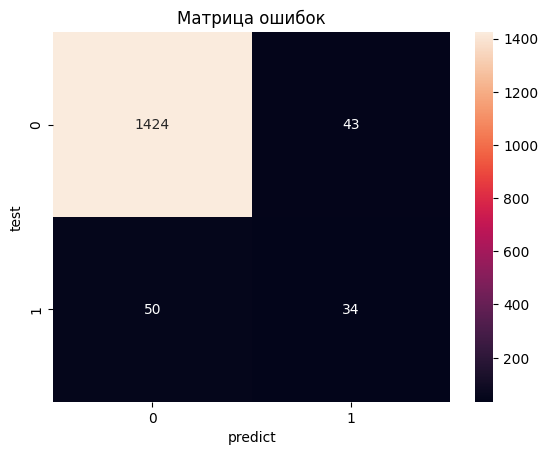

In [113]:
from catboost import CatBoostClassifier

# обучаем модель
model_cb = CatBoostClassifier(n_estimators=100, random_state=203, depth=7, logging_level='Silent', learning_rate=0.5, l2_leaf_reg=7, eval_metric='F1')
model_cb.fit(x_train, y_train)

# оцениваем точность
y_pred = model_cb.predict(x_test)
print_metrics(y_test, y_pred)
print_score(model_cb, x_test)
print_error_matrix(y_test, y_pred) 

# добавлляем прогноз в ансамбль
y_predictions.append(model_cb.predict_proba(x_test)[:, 1])

In [114]:
# ансамбль моделей
y_predictions_proba = pd.DataFrame(y_predictions)
y_pred_proba = y_predictions_proba.sum() / len(y_predictions_proba)

print_metrics(y_test, y_pred_proba.map(lambda x: 0 if x < 0.5 else 1))

Precision: 0.44871794871794873     Recall: 0.4166666666666667
Accuracy: 0.9406834300451322
F1: 0.43209876543209874


Был использован достаточно простой алгоритм ансамбля - взятие среднего среди прогнозов. Такой способ позволил легче определять слабые и сильные модели. Для ансамбля каждый раз выбирались лучшие модели. Для соревнования Kaggle была использована модель Extreme Gradient Boosting, а не ансамбль. Она показала лучшую точность в случае, когда она важнее, чем метрика F1.

#### Подбор параметров
Подготовить датасет - это лишь пол дела. Не менее важно установить правильные параметры у моделей.
Некоторые из параметров можно выставить вполне себе осмысленно, вот только таких параметров меньшенство. Поэтому официальный сайт scikit-learn предлагает несколько методов для настройки параметров модели:
- Exhaustive Grid Search
- Randomized Parameter Optimization
- Searching for optimal parameters with successive halving

Ввиду отсутсвия достаточных мощностей и терпения, мы написали свой аналог Exhaustive Grid Search (наполовину ручной, за то с потокоми):

In [115]:
scores = []

def do_step(n):
    #n/=10
    model = LGBMClassifier(random_state=n, n_estimators=600, learning_rate=0.08, max_depth=3, min_child_samples=17, num_leaves=6, n_jobs=-1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    scores.append([n, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)])
    print(n)

# parallel(do_step, list(range(200, 250, 1)), n_workers=8)

# scores = pd.DataFrame(scores)
# scores.set_index(0, inplace=True)
# print('Max: \n', scores[scores[2] == scores[2].max()])
# print('Mean: ', scores[1].mean(), " ", scores[2].mean())
# print('Median: ', scores[1].median(), " ", scores[2].median())
# scores

Данный код использовался для 2 целей: нахождение лучших значений определённого параметра при текущей настроке и для получения настоящего значения метрик путём перебора значения random_state и взятия среднего результата. Конкретно второе применение этого кода было очень полезно для невелирования разброса и получения точного результата - как конкретное изменение метрики повлияло на модель. Сейчас там установлена LGBMClassifier модель и её параметры. Вместо неё может быть использована любая другая с её параметрами.

В связке был также использован инструмент GridSearchCV. Он в разы дольше и менее точноый, но позволяет с небольшим колчеством усилий найти стартовые занчения для дальнейшей более точной настройки.

In [116]:
from sklearn.model_selection import GridSearchCV

# вывод лучших результатов
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def run_arrange(param_grid, model) :
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=4, n_jobs=-1, scoring='roc_auc', verbose=5 )
    start = time()
    grid_search.fit(x_train, y_train)

    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
        % (time() - start, len(grid_search.cv_results_['params'])))
    report(grid_search.cv_results_)

# параметры
ct_param_grid = {'n_estimators': np.arange(50, 500, 50),
            'random_state': [203],
            'depth': [3],
            'learning_rate': [0.5],
            'l2_leaf_reg': [6],
            'eval_metric': ['Recall'] }

xgb_param_grid = {'n_estimators': np.arange(100, 800, 100),
            'random_state': [10],
            'max_depth': np.arange(1, 4, 1),
            'colsample_bytree': np.arange(0.3, 0.8, 0.1),
            'subsample': np.arange(0.1, 0.3, 0.05),
            'eta': np.arange(0.1, 0.3, 0.1) }

lgbm_param_grid = {'random_state': [200], 
                'n_estimators': np.arange(100, 1000, 100), 
                'learning_rate': np.arange(0.01, 0.1, 0.01), 
                'max_depth': [2,3,4], 
                'min_child_samples': np.arange(10, 20, 1), 
                'num_leaves': np.arange(3, 8, 1), 
                'n_jobs': [-1] }

#run_arrange(xgb_param_grid, model_xgb)

In [117]:
fi = pd.DataFrame({
    'cols': x_train.columns,
    'imp': model_cb.feature_importances_
}).sort_values('imp', ascending=False)
fi

,cols,imp
0,age,54.745286
4,avg_glucose_level,25.121260
5,never_smoked,7.581628
3,ever_married,6.790475
2,heart_disease,2.049583
6,children,1.857117
1,hypertension,1.854650


# Анализ обучения моделей
По иготам обучения моделей мы получили следующие результаты. Лучшими оказались LGBMClassifier, CatBoostClassifier и XGBClassifier. Из них для ансамбля для итогового результата были взяты LGBMClassifier и CatBoostClassifier. Лучшие метрики представлены ниже:

In [118]:
print_metrics(y_test, y_pred_proba.map(lambda x: 0 if x < 0.5 else 1))
score = roc_auc_score(y_test, y_pred_proba)
print("Score:", score)

Precision: 0.44871794871794873     Recall: 0.4166666666666667
Accuracy: 0.9406834300451322
F1: 0.43209876543209874
Score: 0.9225419547505438


Нам удальсь повысить F1 до 43%, но за счёт снижения точности (на пол процента). Этого результата не достаточно, чтобы делать на нём медицинские прогнозы, но достаточно, чтобы увидеть корреляцию с некоторыми параметрами. По ходу обучения мы встретились с ошибками переобучения деревьев, из-за чего их было решено не брать. Данный результат можно улучшить, если произвести ещё лучший семплинг данных и, возможно, используя обучение нейросетей. 

# Получение результатов
Здесь продемонстрован код, с помошью которого лучшие из полученных моделей используются для создания предсказания на тестовые данные для дальнейшей загрузки в Kaggle. Для обучения использовались все данные, без части данных для теста. 

In [119]:
test_df = pd.read_csv("test.csv", index_col=0)

test_df_clean = transformData(test_df)
test_df_clean

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,never_smoked,Govt_job,Never_worked,Private,Self-employed,children
id,,,,,,,,,,,,,,,
15304,1.0,57.0,0,0,1,0,82.54,33.4,0.33,0,0,0,1,0,0
15305,0.0,70.0,1,0,1,1,72.06,28.5,0.33,0,0,0,1,0,0
15306,1.0,5.0,0,0,0,1,103.72,19.5,0.33,0,0,0,0,0,1
15307,1.0,56.0,0,0,1,1,69.24,41.4,1.00,0,1,0,0,0,0
15308,0.0,32.0,0,0,1,0,111.15,30.1,1.00,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25503,1.0,27.0,0,0,0,1,75.77,17.6,0.00,1,0,0,1,0,0
25504,0.0,49.0,0,0,1,1,102.91,26.7,0.33,0,0,0,1,0,0
25505,1.0,3.0,0,0,0,0,104.04,18.3,0.33,0,0,0,0,0,1


In [120]:
x_train, y_train = all_featers, factor

zero_idx = np.array(y_train[y_train == 0].index)
subset_idx = np.random.RandomState(42).choice(zero_idx, size=int(0.7*len(zero_idx)), replace=False)

one_idx = np.array(y_train[y_train == 1].index)
c = np.concatenate((subset_idx, one_idx), axis=0)
print(len(x_train))
x_train = x_train.loc[c].sort_index()
y_train = y_train.loc[c].sort_index()
print(len(x_train))
##
tomek = TomekLinks()
x_train, y_train = tomek.fit_resample(x_train, y_train)
print(len(x_train))
##
smote = SMOTE(sampling_strategy=0.13, random_state=8765)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
print(len(x_train_smote))
print("теперь равно нулю: ", len(y_train_smote[y_train_smote==0]))
print("изначально равно нулю: ", len(y_train[y_train==0]))
print("теперь равно еденице: ", len(y_train_smote[y_train_smote==1]))
print("изначально равно еденице: ", len(y_train[y_train==1]))
x_train = x_train_smote
y_train = y_train_smote
##
model_cb = CatBoostClassifier(n_estimators=100, random_state=203, depth=7, logging_level='Silent', learning_rate=0.5, l2_leaf_reg=7, eval_metric='F1')
model_cb.fit(x_train, y_train)

lgbm_model = LGBMClassifier(random_state=200, n_estimators=600, learning_rate=0.08, max_depth=3, min_child_samples=17, num_leaves=6, n_jobs=-1)
lgbm_model.fit(x_train, y_train)

15513
11111
10839
11297
теперь равно нулю:  9998
изначально равно нулю:  9998
теперь равно еденице:  1299
изначально равно еденице:  841


LGBMClassifier(learning_rate=0.08, max_depth=3, min_child_samples=17,
               n_estimators=600, num_leaves=6, random_state=200)

In [121]:
# избавление от незначащих фич
test_df_clean = test_df_clean.filter(features.index)
test_df_clean

,age,hypertension,heart_disease,ever_married,avg_glucose_level,never_smoked,children
id,,,,,,,
15304,57.0,0,0,1,82.54,0,0
15305,70.0,1,0,1,72.06,0,0
15306,5.0,0,0,0,103.72,0,1
15307,56.0,0,0,1,69.24,0,0
15308,32.0,0,0,1,111.15,0,0
...,...,...,...,...,...,...,...
25503,27.0,0,0,0,75.77,1,0
25504,49.0,0,0,1,102.91,0,0
25505,3.0,0,0,0,104.04,0,1


In [122]:
y_predictions = []
y_predictions.append(model_cb.predict_proba(test_df_clean)[:, 1])
y_predictions.append(lgbm_model.predict_proba(test_df_clean)[:, 1])
#y_predictions.append(model_xgb.predict_proba(test_df_clean)[:, 1])

y_predictions_proba = pd.DataFrame(y_predictions)
y_pred_proba = y_predictions_proba.sum() / len(y_predictions_proba)

In [123]:
#y_pred_proba = rf_model.predict_proba(test_df_clean)[:, 1]

submission = pd.DataFrame({
    "id" : test_df_clean.index,
    "stroke" : y_pred_proba,
})


submission.to_csv("our_result.csv", index=False)

testing = pd.read_csv("our_result.csv")
testing.head()

,id,stroke
0,15304,0.084728
1,15305,0.310768
2,15306,0.000875
3,15307,0.054325
4,15308,0.013567


In [124]:
len(testing)

10204

Результаты на Kaggle:

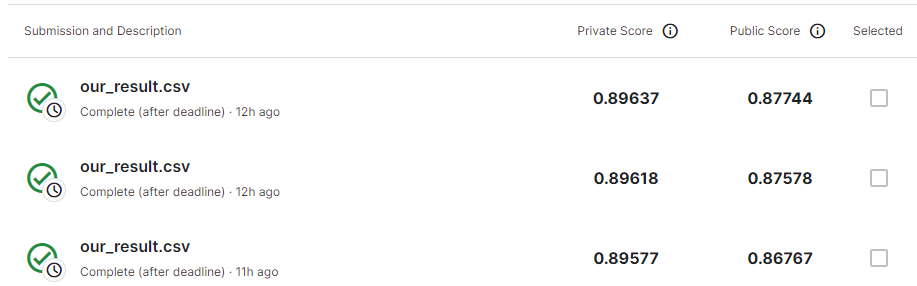

Здесь лучший результат (public: 0.89637; private: 0.87744) был полученен без использования семплинга, как в предворительном обучении. F1 метрика, соответствено, там очень низкая. 

На следующем изображении представлены результаты полученные при максимизации F1 метрики, как описано в данном ноутбуке.

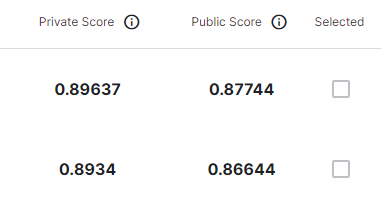

Как бы вы оценили наше знание Machine Learning (0.1-1.0)?

Мы приняты?

Ответы присылать на почту: *maxim.geer@yandex.ru*